##### **Name:** Rohan Karthikeyan
##### **Roll Number:** MDS202226

In the first task of our midsemester exam, we will be performing port-based traffic classification on the given dataset.

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 90)

In [2]:
%%time
# Read the data
data_path = '../input/ip-network-traffic-flows-labeled-with-87-apps/Dataset-Unicauca-Version2-87Atts.csv'

# Convert the Timestamp column to datetime format
flow_data = pd.read_csv(data_path, parse_dates = ['Timestamp'], date_format = '%d/%m/%Y%H:%M:%S')
flow_data

CPU times: user 40.7 s, sys: 9.28 s, total: 50 s
Wall time: 1min 4s


,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,2017-04-26 11:11:17,45523,22,55,132,110414.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,2017-04-26 11:11:17,1,2,0,12,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,2017-04-26 11:11:17,1,3,0,674,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,2017-04-26 11:11:17,217,1,3,0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,2017-04-26 11:11:17,78068,5,0,1076,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577291,10.200.7.199-98.138.79.73-42135-443-6,98.138.79.73,443,10.200.7.199,42135,6,2017-05-15 05:43:40,2290821,5,4,599,2159.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577292,10.200.7.217-98.138.79.73-51546-443-6,98.138.79.73,443,10.200.7.217,51546,6,2017-05-15 05:46:10,24,5,0,1448,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577293,10.200.7.218-98.138.79.73-44366-443-6,98.138.79.73,443,10.200.7.218,44366,6,2017-05-15 05:45:39,2591653,6,5,1202,4184.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL
3577294,10.200.7.195-98.138.79.73-52341-443-6,98.138.79.73,443,10.200.7.195,52341,6,2017-05-15 05:45:59,2622421,4,3,632,2352.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,91,SSL


### Q0: Perform port-based classification

The classification process usually takes place by inspecting the TCP and UDP packets’ port numbers which are mapped to the predefined ports by IANA. For example, if the inspected port number is 80, it corresponds to the HTTP protocol.

**Disadvantages:** 
1. These days, many applications deploy masquerading, i.e., using standard ports to deliver other protocol traffic, such as malware traffic over HTTP. 
2. Many applications are deployed randomly, which refers to the utilization of non-standard/dynamic ports to deliver their network traffic, such as VoIP applications.

**Our approach:** For every source or destination port, we check the underlying services/applications that have been used.

#### Applications used on (source/destination) port

Let us first get a sample of the source and destination ports along with the name of the underlying protocol.

In [3]:
flow_data[['Source.Port', 'Destination.Port', 'ProtocolName']].sample(25)

,Source.Port,Destination.Port,ProtocolName
3085679,49513,443,WINDOWS_UPDATE
780187,3128,59110,HTTP
916843,3128,35336,HTTP
397071,51819,3128,WINDOWS_UPDATE
1309178,3128,51394,HTTP
3240116,53424,80,GOOGLE
358169,42600,80,GOOGLE
2802966,53715,3128,HTTP_CONNECT
1860498,64298,3128,HTTP_CONNECT
3550807,62274,3128,HTTP_PROXY


If we consider the cell above, we can observe that the `ProtocolName` is not determined exclusively by the `Source.Port` column. <br> Hence, it is better to analyze **both** the source and destination ports. 

To this end, we obtain the unique services used on either the source port or the destination port.

In [4]:
%%time

def replace_with_empty_list(x):
    if x is np.nan:
        return []
    else:
        return x

from itertools import chain

def method1_mend(df):
    unrolled_df = df.to_dict('list')
    return pd.Series([list(set(chain.from_iterable(t))) for t in zip(*unrolled_df.values())],
                     index=df.index)

def get_unique_services(data):
    """
    Get unique services used on either source or destination port.
    """
    # Applications used on source ports
    source = data.groupby(['Source.Port']).apply(lambda x: x['ProtocolName'].unique())
    source = pd.DataFrame(source, columns = ['Services'])
    source.index.names = ['Port']

    # Applications used on destination ports
    dest = data.groupby(['Destination.Port']).apply(lambda x: x['ProtocolName'].unique())
    dest = pd.DataFrame(dest, columns = ['Services'])
    dest.index.names = ['Port']

    # Applications used on some port (source or destination)
    all_services = source.join(dest, how='outer', lsuffix = '_Source', rsuffix = '_Destination')
    # Replace NaNs with empty list
    all_services = all_services.applymap(replace_with_empty_list)

    # Get unique services
    uniq_services = pd.DataFrame(method1_mend(all_services), columns=['Uniq_Services'])

    # Join with all_services
    all_services = all_services.join(uniq_services)
    # Drop earlier columns
    all_services.drop(columns=['Services_Source', 'Services_Destination'], inplace=True)
    all_services.reset_index(inplace=True)
    return all_services

CPU times: user 15 µs, sys: 4 µs, total: 19 µs
Wall time: 23.1 µs


In [5]:
all_services = get_unique_services(flow_data)
all_services

,Port,Uniq_Services
0,0,"[IP_ICMP, HTTP, HTTP_PROXY, GOOGLE, HTTP_CONNECT]"
1,21,[FTP_CONTROL]
2,22,"[SSH, SSL]"
3,53,"[TWITTER, YOUTUBE, MICROSOFT, GMAIL, SKYPE, AP..."
4,80,"[SIMET, GOOGLE_MAPS, CLOUDFLARE, INSTAGRAM, MQ..."
...,...,...
40974,65530,"[HTTP_PROXY, GOOGLE, HTTP, HTTP_CONNECT]"
40975,65531,"[HTTP, MICROSOFT, GOOGLE, HTTP_CONNECT, WINDOW..."
40976,65532,"[YOUTUBE, HTTP, GMAIL, HTTP_PROXY, GOOGLE, HTT..."
40977,65533,"[YOUTUBE, HTTP_PROXY, GOOGLE, HTTP_CONNECT, MI..."


Now, port numbers are classified into three ranges:
* System ports (0 – 1023);
* User ports (1024 – 49,151), and 
* Dynamic ports (49,152 – 65,535)

We now look at the first category of system ports.

In [6]:
# First category: System ports
sys_ports = all_services[all_services['Port'] < 1024].reset_index(drop=True)
sys_ports['NumServices'] = sys_ports.Uniq_Services.apply(lambda x: len(x))
sys_ports

,Port,Uniq_Services,NumServices
0,0,"[IP_ICMP, HTTP, HTTP_PROXY, GOOGLE, HTTP_CONNECT]",5
1,21,[FTP_CONTROL],1
2,22,"[SSH, SSL]",2
3,53,"[TWITTER, YOUTUBE, MICROSOFT, GMAIL, SKYPE, AP...",11
4,80,"[SIMET, GOOGLE_MAPS, CLOUDFLARE, INSTAGRAM, MQ...",39
5,81,[HTTP],1
6,83,[HTTP],1
7,91,[HTTP],1
8,92,[HTTP],1
9,123,[NTP],1


In [7]:
# Looking at Port 80's record
print(sys_ports.iloc[4, 1])

['SIMET', 'GOOGLE_MAPS', 'CLOUDFLARE', 'INSTAGRAM', 'MQTT', 'SPOTIFY', 'GMAIL', 'HTTP_DOWNLOAD', 'MICROSOFT', 'WINDOWS_UPDATE', 'QQ', 'EDONKEY', 'CNN', 'APPLE_ITUNES', 'SSL', 'HTTP', 'CONTENT_FLASH', 'APPLE', 'FTP_DATA', 'YAHOO', 'AMAZON', 'BITTORRENT', 'EBAY', 'NETFLIX', 'SKYPE', 'GOOGLE', 'UBUNTUONE', 'MS_ONE_DRIVE', 'TWITTER', 'OFFICE_365', 'MSN', 'YOUTUBE', 'DEEZER', 'EASYTAXI', 'FACEBOOK', '99TAXI', 'TIMMEU', 'DROPBOX', 'WIKIPEDIA']


**Conclusions:**

1. IANA has actually [reserved port 0](https://networkengineering.stackexchange.com/questions/76587/where-are-0-tcp-udp-ports-banned). So, I'm not sure how services can use them.
2. SSH has its place in port 22. So do FTP_CONTROL (21), DNS (53), NTP (123), SNMP (161) and MAIL_IMAPS (993).
3. We can see that 38 specific services have been used on HTTP and 39 services used on HTTPS.
4. HTTP used on ports 81, 83, 91, 92 and SSL on port 444 seem to instances of port masking.

Therefore, we could have correctly identified ports 21, 22, 53, 80, 123, 161, 443 and 993 using port-based classification (because we also have the ground-truth labels). I am ignoring the specific applications that have been decoded by the authors for the ports.

Let us see the percentage of records that belong to these ports:

In [8]:
correct_ports = [21, 22, 53, 80, 123, 161, 443, 993]
correct_classification = flow_data[np.logical_or(flow_data['Source.Port'].isin(correct_ports),
                                                 flow_data['Destination.Port'].isin(correct_ports))]

percent_records = len(correct_classification)/len(flow_data)
print('We could have "correctly" identified {:.2%} records.'.format(percent_records))

We could have "correctly" identified 42.53% records.


We move on to the second category of user ports.

In [9]:
# Second category: User ports
usr_ports = all_services[np.logical_and(all_services['Port'] >= 1024,
                                        all_services['Port'] < 49152)].reset_index(drop=True)
usr_ports['NumServices'] = usr_ports.Uniq_Services.apply(lambda x: len(x))
usr_ports

,Port,Uniq_Services,NumServices
0,1024,"[HTTP_PROXY, GOOGLE, HTTP, HTTP_CONNECT]",4
1,1025,"[HTTP_PROXY, GOOGLE, HTTP, MSN]",4
2,1026,"[YOUTUBE, HTTP, HTTP_PROXY, GOOGLE, HTTP_CONNECT]",5
3,1027,"[HTTP, HTTP_PROXY, FACEBOOK, GOOGLE, HTTP_CONN...",5
4,1028,"[HTTP, SKYPE, HTTP_PROXY, FACEBOOK, GOOGLE, HT...",6
...,...,...,...
24577,49147,"[TWITTER, YOUTUBE, SSL, HTTP, SKYPE, GOOGLE, A...",8
24578,49148,"[YOUTUBE, SSL, HTTP, SKYPE, GOOGLE, AMAZON, MI...",7
24579,49149,"[CLOUDFLARE, YOUTUBE, SSL, HTTP, SKYPE, FACEBO...",10
24580,49150,"[YOUTUBE, SSL, HTTP, GOOGLE, AMAZON, MICROSOFT]",6


The sheer number of user ports precludes a case-by-case analysis.

We'll not look at port numbers greater than 49152, because there's no mapping between those ports and protocols.

### Q1: How many flows are present in the dataset?

It is beneficial to recall the definition of a *flow*:
> A flow is, most of the times, defined as a set of packets that share the same key: source and destination IP addresses and transport port numbers.

In our case, we have a very helpful `Flow.ID` column that has the flow key for us. Now, consider the first two rows of our data:

In [10]:
%%time
flow_data.head(2)

CPU times: user 376 µs, sys: 71 µs, total: 447 µs
Wall time: 490 µs


,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,2017-04-26 11:11:17,45523,22,55,132,110414.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,2017-04-26 11:11:17,1,2,0,12,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


If you observe closely, the source IP and destination IP reverse their roles while moving from the first record to the second. But the Flow ID is the same! 

These flows are ***bidirectional***, where we consider the packets travelling between two address-port pairs in both directions as a single flow.

**Conclusion:** We therefore answer the question by considering the number of unique flows (also taking into account the timestamp information).

In [11]:
%%time
# Number of unique flows
print('There are {} unique flows in the dataset.'.format(flow_data[['Flow.ID', 'Timestamp']].nunique()[0]))

There are 1522917 unique flows in the dataset.
CPU times: user 1.16 s, sys: 1.84 ms, total: 1.16 s
Wall time: 1.17 s


### Q3: What are the total number of bytes sent across the network? What is the flow duration?

Let us first take a look at some relevant columns for this question:

In [12]:
cols = ['Total.Fwd.Packets', 'Total.Backward.Packets', 
        'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
        'Fwd.Header.Length', 'Bwd.Header.Length']
flow_data[cols]

,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,Fwd.Header.Length,Bwd.Header.Length
0,22,55,132,110414.0,440,1100
1,2,0,12,0.0,40,0
2,3,0,674,0.0,96,0
3,1,3,0,0.0,32,96
4,5,0,1076,0.0,100,0
...,...,...,...,...,...,...
3577291,5,4,599,2159.0,160,128
3577292,5,0,1448,0.0,160,0
3577293,6,5,1202,4184.0,192,160
3577294,4,3,632,2352.0,128,96


**Observations:** 
1. There are records where `Total.Length.of.Fwd.Packets` is smaller than `Fwd.Header.Length`. 
2. Furthermore, if we look at the record with index 3, looking at the header lengths tells us that each packet has a header length of 32 bytes.

**Approach:**
* For the first part, we make use of the columns: `Total.Length.of.Fwd.Packets` and `Total.Length.of.Bwd.Packets`. 
* For the second part, we make use of the `Flow.Duration` column.

In [13]:
%%time
# Create new column
flow_data['Total.Length.of.Packets'] = flow_data['Total.Length.of.Fwd.Packets'] + flow_data['Total.Length.of.Bwd.Packets']

# Total number of bytes sent
total_bytes = flow_data['Total.Length.of.Packets'].sum()
print('{} GB was sent across the network (considering all days).'.format(round(total_bytes/1e9), 3))

470 GB was sent across the network (considering all days).
CPU times: user 32.9 ms, sys: 356 µs, total: 33.3 ms
Wall time: 21.4 ms


Before we look at the next part, it is worth to look at some statistics of the Flow Duration column: <br>
**NOTE:** The unit of the flow duration is in _microseconds_.

In [14]:
%%time
flow_data['Flow.Duration'].describe().to_frame()

CPU times: user 108 ms, sys: 1.05 ms, total: 109 ms
Wall time: 109 ms


,Flow.Duration
count,3.577296e+06
mean,2.544247e+07
std,4.014430e+07
min,1.000000e+00
25%,6.280000e+02
50%,5.847295e+05
75%,4.500153e+07
max,1.200000e+08


The duration of a ***bidirectional (aggregate) flow*** is the sum of the durations of the unidirectional (base) flows that make up the bidirectional flow ([Source](https://emc.extremenetworks.com/content/oneview/docs/analytics/analytics_tab/application_flows/c_ea_appflows_tab_bidirect.htm#:~:text=The%20duration%20of%20a%20bidirectional,Seen%20and%20Last%20Seen%20Time.)).

In [15]:
%%time
# Flow duration
time_all_flows = pd.DataFrame(flow_data.groupby(['Flow.ID'])['Flow.Duration'].sum()/1e6)
time_all_flows.reset_index(inplace=True)
time_all_flows.columns = ['Flow.ID', 'Duration (secs)']
time_all_flows

CPU times: user 4.16 s, sys: 10.6 ms, total: 4.17 s
Wall time: 4.17 s


,Flow.ID,Duration (secs)
0,10.130.0.157-10.200.7.4-56398-3128-6,0.004969
1,10.130.0.157-10.200.7.4-56399-3128-6,0.003121
2,10.130.0.157-10.200.7.4-56405-3128-6,0.205598
3,10.130.0.157-10.200.7.4-56408-3128-6,0.207268
4,10.130.0.157-10.200.7.4-56413-3128-6,0.210308
...,...,...
1522912,8.5.1.51-10.200.7.218-80-53686-6,0.284719
1522913,8.5.1.51-10.200.7.218-80-53688-6,0.280582
1522914,8.5.1.51-10.200.7.218-80-53733-6,0.281750
1522915,8.5.1.51-10.200.7.218-80-53738-6,0.274965


<Axes: ylabel='Frequency'>

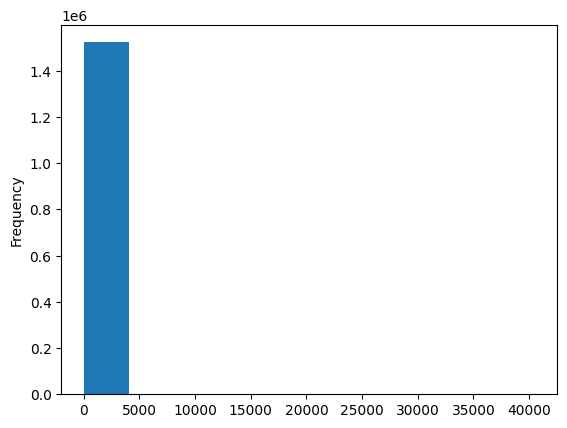

In [16]:
# A plot of the flow durations
time_all_flows['Duration (secs)'].plot(kind='hist')

It seems that there are a few outliers.

### Q4: What are the big flows?

From Q3, we observed that there are flows with a very long duration. It is worthwhile to explore the flows that are greater than the 99th percentile in duration. 

In [17]:
# Big flows by time duration
time_big_flows = pd.DataFrame(flow_data.groupby(['Flow.ID'])[['Flow.Duration', 'Total.Length.of.Packets']].sum()/1e6)
time_big_flows.reset_index(inplace=True)
time_big_flows.columns = ['Flow.ID', 'Duration (secs)', 'Bytes (MB)']

# Get 99th percentile of duration
p99 = np.round(np.percentile(time_big_flows['Duration (secs)'], 99), 3)

# Subset the flows
time_big_flows[time_big_flows['Duration (secs)'] > p99]

,Flow.ID,Duration (secs),Bytes (MB)
7812,10.200.7.194-104.154.127.81-36515-4070-6,1690.328089,0.034315
9227,10.200.7.194-104.208.156.39-43312-443-6,1509.892098,0.012139
9229,10.200.7.194-104.208.156.39-46400-443-6,3240.745715,0.026218
9234,10.200.7.194-104.208.156.39-56752-443-6,3230.232432,0.036699
9706,10.200.7.194-104.244.42.1-33938-443-6,1520.005044,0.072200
...,...,...,...
1519577,5.231.220.81-10.200.7.199-9000-45226-6,1407.157428,2.606117
1520574,8.30.11.130-10.200.7.199-80-33231-6,1536.718872,0.191076
1520580,8.30.11.134-10.200.7.196-80-47045-6,1212.947684,0.134651
1520581,8.30.11.134-10.200.7.196-80-48049-6,2751.495005,0.340667


Let us plot a scatterplot of the two numeric columns:

<Axes: xlabel='Duration (secs)', ylabel='Bytes (MB)'>

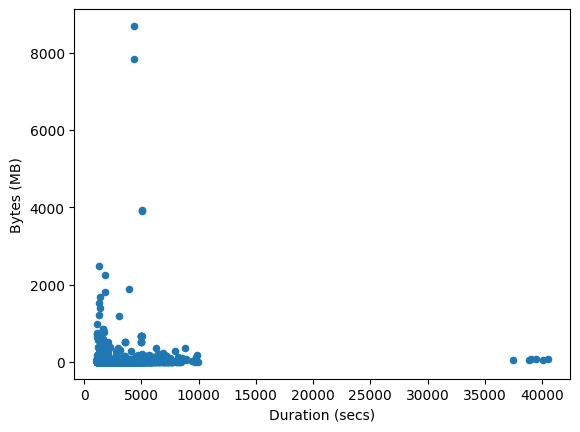

In [18]:
time_big_flows[time_big_flows['Duration (secs)'] > p99].plot(kind = 'scatter', x = 'Duration (secs)', y = 'Bytes (MB)')

**Observation:** <br> Flows that last for more than 35000 secs (see bottom right) actually don't consume a lot of bytes compared to some mid-timed flows where almost 8 GB flowed between the source and destination.

Let us also look at flows that are greater than the 99th percentile in bytes sent across the network.

In [19]:
# Get 99th percentile of duration
p99 = np.round(np.percentile(time_big_flows['Bytes (MB)'], 99), 3)

# Subset the flows
time_big_flows[time_big_flows['Bytes (MB)'] > p99]

,Flow.ID,Duration (secs),Bytes (MB)
4175,10.200.1.16-10.200.7.217-443-49759-6,156.768505,8.872372
5712,10.200.1.230-10.200.7.194-80-32987-6,15.522275,3.889206
5765,10.200.1.230-10.200.7.195-80-38351-6,16.928818,5.082537
5767,10.200.1.230-10.200.7.195-80-40870-6,15.212718,5.655903
5771,10.200.1.230-10.200.7.195-80-41305-6,16.274136,7.080543
...,...,...,...
1520489,8.254.208.202-10.200.7.194-443-41830-6,51.113966,5.373810
1520500,8.254.208.206-10.200.7.199-80-59606-6,416.948419,7.624583
1520541,8.254.225.184-10.200.7.194-443-60778-6,6.663582,16.732814
1520542,8.254.225.184-10.200.7.194-443-60959-6,13.622914,33.082097


The earlier dataframe had 15230 rows, a mere 2 rows more than this one. Let us make our scatterplot:

<Axes: xlabel='Duration (secs)', ylabel='Bytes (MB)'>

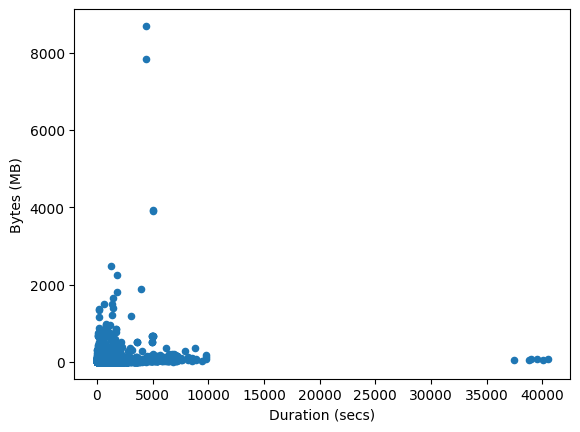

In [20]:
time_big_flows[time_big_flows['Bytes (MB)'] > p99].plot(kind = 'scatter', x = 'Duration (secs)', y = 'Bytes (MB)')

**Observation:** There is ***almost no difference*** between the two plots!